In [10]:
import pandas as pd
import random
import time
import os
import numpy as np

In [6]:
from loadNetParams import *
from models import *
from mxnet.gluon import loss
from mxnet.gluon.trainer import Trainer
from mxnet import autograd, init
import mxnet.ndarray as nd
from imblearn.over_sampling import RandomOverSampler
from mxnet.gluon import data as gdata

In [7]:
from mxboard import *

In [4]:
def load_data():
    genelist = pd.read_csv('data/symbol_nodes.csv', sep='\t', header=None)
    hgncFile = pd.read_csv('E:/wx/2019上课题/数据/hgnc_complete_set.txt', sep='\t',
                               usecols=['symbol', 'ensembl_gene_id', ],
                               engine='python')
    symbol2ensg = hgncFile.loc[hgncFile['symbol'].isin(genelist[0])]
    exp_list = []
    ensembl_list = list(symbol2ensg['ensembl_gene_id'])
    with open('E:/wx/2019上课题/数据/exp/TCGA-CHOL.htseq_fpkm-uq.tsv', 'r') as file:
        headerline = file.readline().split('\t')
        for f in file.readlines():
            enseID = f.split('\t')
            ensgid = enseID[0].split('.')[0]
            if ensgid in ensembl_list:
                symbolname = symbol2ensg.loc[symbol2ensg['ensembl_gene_id']==ensgid, 'symbol'].values[0]
                tmp = enseID[1:]
                tmp.insert(0, str(symbolname))
                exp_list.append(tmp)

    exp_mat = pd.DataFrame(exp_list, columns=headerline)
    exp_mat = exp_mat.set_index(exp_mat['Ensembl_ID']).drop(['Ensembl_ID'], axis = 1).astype('float')

    samples = list(exp_mat.columns)
    case_samples = []
    control_samples = []
    for i in samples:
        if int(i.strip()[-3:-2]) == 0:
            case_samples.append(i)
        else:
            control_samples.append(i)

    labels = [[1, 0][int(i.strip()[-3:-2])] for i in samples]
    sample_label_dict = dict(zip(samples, labels))

    case_num = len(case_samples)
    control_num = len(control_samples)

    p = 0.8

    train_num_case = int(case_num * p)
    train_num_control = int(control_num * p)

    train_x_samples = random.sample(case_samples, train_num_case)
    train_x_samples.extend(random.sample(control_samples, train_num_control))
    
    random.shuffle(train_x_samples)
    train_x = exp_mat[train_x_samples]
    def _get_label(label):
        cateory = sorted(list(set(label))) # 类别列表
        cateory_dict = dict(zip(cateory, list(range(len(cateory)))))
        train_y = nd.zeros(shape=(len(label), len(cateory)))
        
        for i, y in enumerate(label):
            train_y[i, cateory_dict[y]] = 1
        return train_y
    # train_y = [sample_label_dict[y] for y in train_x_samples]
    # train_y = _get_label(train_x_samples, sample_label_dict)
    train_y = [sample_label_dict[y] for y in train_x_samples] # 原始标签
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_sample(train_x.T, train_y) # 过采样
    # y_resampled_change = _get_label(y_resampled) # 变换标签
    
    test_x_samples = list(set(samples) - set(train_x_samples))
    random.shuffle(test_x_samples)
    test_x = exp_mat[test_x_samples]
    
    test_y = [sample_label_dict[y] for y in test_x_samples] # 原始标签
    ros_test = RandomOverSampler(random_state=0)
    X_resampled_test, y_resampled_test = ros_test.fit_sample(test_x.T, test_y) # 过采样
    # y_resampled_test_change = _get_label(y_resampled_test) # 变换标签
    # test_y = _get_label(test_x_samples, sample_label_dict)
    with open('data/allData.pickle.txt', 'wb') as f:
        pickle.dump({'train_x': X_resampled, 'train_y': y_resampled, 'test_x': X_resampled_test, 'test_y': y_resampled_test}, f)
    return X_resampled, y_resampled, X_resampled_test, y_resampled_test

In [5]:
def _norm_input(X, eps=1e-6):
    mean = X.mean(axis=1).reshape(-1,1)
    variance = ((X-mean)**2).mean(axis=1).reshape(-1,1)
    return (X - mean) / nd.sqrt(variance + eps)
def _norm_zero_one(aa):
    return (aa - aa.min(axis=1, keepdims=True)) / (aa.max(axis=1, keepdims=True) - aa.min(axis=1, keepdims=True))
def data_iter(batch_size, x, y):
    x = nd.array(x)
    num_samples, M = x.shape
    indices = list(range(num_samples))
    random.shuffle(indices)
    for i in range(0, num_samples, batch_size):
        j = indices[i: min(i + batch_size, num_samples)]
        res = nd.array(x[j,:])#_norm_zero_one(nd.array(x[j,:])) # nd.array(x[j,:])# 
        yield res.reshape((res.shape[0], M, 1)), nd.array(y[j])

In [6]:
def evaluate_accuracy(test_x, test_y, net):
    acc, n = 0.0, 0
    for X, Y in data_iter(batch_size, test_x, test_y):
        pre = net(X)
        acc += (pre.argmax(axis=1)==Y).sum().asscalar()
        n += X.shape[0]
    return acc / n

def train(data_iter, net, cross_entropy, trainer, num_epochs, batch_size):
    sw = SummaryWriter(logdir='./logs', flush_secs=2)
    params = net.collect_params('.*W|.*dense')
    param_names = params.keys()
    ls = 0
    # train_x, train_y, test_x, test_y = allData['train_x'], allData['train_y'], allData['test_x'], allData['test_y']
    for epoch in range(num_epochs):
        train_loss_sum, train_acc_sum, n, start = 0., 0., 0., time.time()
        for X, Y in data_iter:
            #X.attach_grad()
            with autograd.record():
                pre = net(X.reshape(*X.shape, 1))
                loss = cross_entropy(pre, Y).sum()
            loss.backward()
            trainer.step(batch_size)
            
            # 记录
            train_loss_sum += loss.asscalar()
            train_acc_sum += (pre.argmax(axis=1)==Y).sum().asscalar()
            n += len(Y)
            sw.add_histogram(tag='cross_entropy', values=train_loss_sum / n, global_step=ls)
            ls+=1
            
            # 第一次训练，记录图结构
            # if epoch == 0:
            #     sw.add_graph(net)
            # 记录梯度
            # grads = [i.data() for i in net.collect_params().values()]
            # assert len(grads) == len(param_names)
            # logging the gradients of parameters for checking convergence
            for i, name in enumerate(param_names):
                sw.add_histogram(tag=name, 
                                 values=net.collect_params()[name].grad(), 
                                 global_step=ls, bins=1000) 
                
            # net.collect_params()['hybridsequential0_hybridsequential0_graphconvolution0_W'].grad()
            
        # test_acc = evaluate_accuracy(test_x, test_y, net)
        print('epoch %d, loss %.4f, train acc %.3f,  time %.1f sec' % 
              (epoch + 1, train_loss_sum / n, train_acc_sum / n,  time.time() - start))
    sw.close()
    return net

In [8]:
def processSample():
    root = 'data/raw_exp'
    file_list = os.listdir(root)
    file_labels = dict(zip(file_list, list(range(1,len(file_list)+1))))
    samples_list = []
    
    for file in file_list:
        with open(os.path.join(root,file), 'r') as f:
            first_row = f.readline()
            first_row = first_row.strip().split('\t')
            for sample in first_row[1:]:
                if int(sample.strip()[-3:-2]) == 0:
                    # case
                    samples_list.append((sample, file_labels[file]))
                else:
                    # control
                    samples_list.append((sample, 0))
    m = np.array(samples_list)
    np.save('data/sampleList.npy',m)

def load_all_data(reload=False):
    if reload:
        processSample()
    a = np.load('data/sampleList.npy')
    samples_list=a.tolist()
    
    sample2labels = pd.DataFrame(samples_list,columns=['sampleID', 'label'])
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_sample(np.array(sample2labels['sampleID']).reshape(-1, 1), 
                                              np.array(sample2labels['label'])
                                             ) # 过采样
    allsamples = pd.DataFrame({'sampleID':X_resampled[:,0], 'label':y_resampled})
    length = allsamples.shape[0]
    index_list = list(range(length))
    train_num, validation_num, test_num= 0.7, 0.2, 0.1
    random.shuffle(index_list)
    train_index = index_list[0:int(length*train_num)]
    validation_index = index_list[int(length*train_num): int(length*train_num) + int(length*validation_num)]
    test_index = index_list[int(length * train_num) + int(length * validation_num):]

    train_samples = allsamples.loc[train_index]
    validation_samples = allsamples.loc[validation_index]
    test_samples = allsamples.loc[test_index]
    
    return train_samples, validation_samples, test_samples

In [11]:
processSample()

In [8]:
dataset = LoadData()
net, feature = train_model(dataset)

E:\wx\2019上课题\程序\GCN\gcn\loadNetParams.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.res['entryID'] = self.res[1].map(geneset2entryID).apply(lambda x: 'entry' + str(x))


加载ppi网络数据...
加载蛋白与entry对应关系数据...
加载entry网络...
加载entry与pathway对应关系数据...
加载pathway网络数据...
构建神经网络模型...


In [9]:
net.initialize()

In [10]:
x=nd.random.normal(0,1,shape=(2,7394,1))
# nd.diag(x).reshape(1,7394,7394)

In [11]:
net(x)


[[ 1.0143557e-04 -2.3444915e-04  6.2333122e-05 -1.1161713e-04
   1.4005442e-05 -1.7166403e-04  6.9735805e-04  1.4187398e-04
  -2.3085340e-04  4.0351483e-04  4.2122288e-04 -6.0431212e-05
   1.7657304e-04  7.1207253e-04  2.5145034e-04  2.3912571e-04
  -2.0535027e-04 -3.0160527e-04  3.1001412e-04 -3.6734590e-04
  -1.3959217e-04  9.7705773e-04 -5.7258777e-04 -5.3115214e-06
  -2.9715474e-04  5.3588225e-04  5.9082118e-05  4.7016121e-04
   4.0148952e-04  5.7449995e-04 -2.6691731e-04 -7.1188918e-04
  -5.1807374e-04]
 [ 2.6461134e-05 -1.9125990e-04  2.7640196e-04 -3.1096669e-04
   4.1420467e-04 -2.3697394e-04  8.5043150e-04  4.6268839e-04
  -6.5314706e-04  5.3036649e-04  7.8397314e-04  3.0238181e-04
   3.6678382e-04  4.1025074e-04  6.6065928e-04  1.3807695e-04
  -3.8629916e-04 -6.4818509e-04  6.6142238e-04 -6.0501078e-04
  -2.3951779e-04  1.7628785e-03 -7.5477321e-04  1.2393345e-05
  -3.8179918e-04  5.7270227e-04 -1.6271832e-04  6.6218886e-04
   6.9769006e-04  8.7256287e-04 -4.2240246e-04 -1.3

In [10]:
batch_size = 10

In [11]:
exp = pd.read_csv('data/exp_data.csv')

In [12]:
train_samples, validation_samples, test_samples = load_all_data()
train_x = nd.array(exp[train_samples['sampleID']]).transpose()
train_y = nd.array(train_samples['label'])

In [13]:
dataset = gdata.ArrayDataset(train_x, train_y)
data_iter = gdata.DataLoader(dataset, batch_size, shuffle=True)

In [16]:
# train_x, train_y, test_x, test_y = load_data()
# import pickle
# with open('data/allData.pickle.txt', 'rb') as f:
#     allData = pickle.load(f)
#train_x, train_y, test_x, test_y = allData['train_x'], allData['train_y'], allData['test_x'], allData['test_y']

In [17]:
# from mxnet.gluon import data as gdata
# dataset_train = gdata.ArrayDataset(train_x, train_y)
# dataset_test = gdata.ArrayDataset(test_x, test_y)
# train_iter = gdata.DataLoader(dataset_train, batch_size, shuffle=True)# data_iter(batch_size, train_x, train_y)
# test_iter = gdata.DataLoader(dataset_test, batch_size, shuffle=True)

In [14]:
cross_entropy = loss.SoftmaxCrossEntropyLoss()
trainer = Trainer(net.collect_params(), 'adam', {'learning_rate': 0.001})

In [ ]:
net_res = train(data_iter, net, cross_entropy, trainer, 20, batch_size)

In [17]:
for x,y in data_iter:
    break

In [18]:
res = net(x.reshape(*x.shape, 1))

In [19]:
res


[[ 0.22197643 -0.2858493   0.06221249 -0.11148123  0.10628767 -0.27649826
   0.9584354   0.20966    -0.34099162  0.4497619   0.5676561  -0.02686727
   0.11561636  0.898434    0.23480862  0.2609749  -0.29488096 -0.25868243
   0.41239706 -0.3001452  -0.15791489  1.0864179  -0.8588755   0.11401797
  -0.4884135   0.71537423  0.02774012  0.57206523  0.5708385   0.75885314
  -0.14341874 -0.820649   -0.5882429 ]
 [ 0.21600108 -0.2778729   0.0619808  -0.11032414  0.10486103 -0.26994547
   0.932429    0.20511092 -0.334379    0.4388912   0.55420613 -0.02491191
   0.11455297  0.8731178   0.23023093  0.25344747 -0.28862712 -0.25404865
   0.40241212 -0.29416883 -0.15389487  1.0600016  -0.83720344  0.11063077
  -0.47656074  0.6974293   0.02617634  0.55830956  0.5571142   0.7393605
  -0.14096561 -0.80217946 -0.57331175]
 [ 0.21679603 -0.27929088  0.06154417 -0.11023895  0.10429574 -0.27080193
   0.9354172   0.2048196  -0.33431086  0.44038418  0.5556349  -0.02614373
   0.11441018  0.87543774  0.23056

In [42]:
res.argmax(axis=1)


[28. 28. 28.]
<NDArray 3 @cpu(0)>

In [66]:
y


[32. 26.  6.]
<NDArray 3 @cpu(0)>

In [68]:
y = nd.array([28,28,28])
y_h = nd.zeros(shape=(y.shape[0],33))
for i, x in enumerate(y):
    y_h[i, x] = 1
y_h


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0.]]
<NDArray 3x33 @cpu(0)>

In [69]:
loss.L2Loss()(res,y_h)


[0.0146642  0.0146628  0.01466368]
<NDArray 3 @cpu(0)>

In [45]:
cross_entropy(res,nd.array([23,28,28]))


[3.4960785 3.4955285 3.4955575]
<NDArray 3 @cpu(0)>

In [1]:
from loadNetParams import *
aa = LoadData()
nn = aa.get_ppi_net(orginal='mint')

E:\wx\2019上课题\程序\GCN\gcn\loadNetParams.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.res['entryID'] = self.res[1].map(geneset2entryID).apply(lambda x: 'entry' + str(x))


In [3]:
nn['A'].shape

(7394, 7394)

In [2]:
gl = aa.genelist_order

In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [5]:
ppi = pd.read_csv('E:/wx/2019上课题/数据/species_human.txt', sep='\t', header=None, usecols=[0,1], engine='python')

In [45]:
ppi_2 = pd.DataFrame(columns=['p1', 'p2'])
ppi_2['p1'] = ppi[0].apply(lambda x: x.split(':')[1])
ppi_2['p2'] = ppi[1].apply(lambda x: x.split(':')[-1])

In [8]:
hgncPath = 'E:/wx/2019上课题/数据/hgnc_complete_set.txt'
hgncFile = pd.read_csv(hgncPath, sep='\t',
                           usecols=['hgnc_id', 'symbol', 'uniprot_ids',],
                           engine='python',
                           dtype={'entrez_id': str})
gene2symbol = hgncFile.loc[hgncFile['symbol'].isin(gl)]

In [37]:
gs = gene2symbol.dropna()
dt = dict(zip(gs.uniprot_ids, gs.symbol))

In [48]:
ppi_3 = pd.DataFrame(columns=['p1', 'p2'])
ppi_3['p2'] = ppi_2['p2'].map(dt)
ppi_3['p1'] = ppi_2['p1'].map(dt)

In [51]:
ppi_3 = ppi_3.dropna()

d:\python36\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


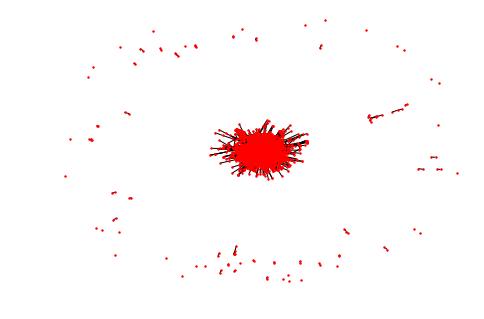

In [52]:
ppi_net_nx = nx.from_pandas_edgelist(ppi_3, 'p1', 'p2')
ppi_A = nd.array(nx.to_numpy_matrix(ppi_net_nx, nodelist=genelist_order))
fig = plt.figure()
nx.draw(ppi_net_nx, with_labels=False,node_size=2)
plt.show()

In [2]:
A = nn['A']
I = nd.eye(*A.shape)
A_hat = A.copy() + I
D = nd.sum(A_hat, axis=0)
D_inv = D ** -1
D_inv = nd.diag(D_inv)
A_hat = nd.dot(D_inv ,A_hat )

In [21]:
train_x, train_y, test_x, test_y = allData['train_x'], allData['train_y'], allData['test_x'], allData['test_y']

In [22]:
iterdata = data_iter(10, train_x, train_y)
for x,y in iterdata:
    break

In [26]:
tt = net_res(x)
tt


[[8.7462855e-04 9.9912542e-01]
 [1.4981413e-03 9.9850190e-01]
 [4.1198485e-02 9.5880151e-01]
 [5.3786696e-04 9.9946219e-01]
 [5.0925901e-03 9.9490744e-01]
 [3.8475855e-04 9.9961519e-01]
 [1.7777274e-04 9.9982220e-01]
 [2.6104555e-03 9.9738961e-01]
 [2.8606644e-03 9.9713933e-01]
 [4.5818039e-03 9.9541819e-01]]
<NDArray 10x2 @cpu(0)>

In [25]:
y


[1. 0. 1. 0. 0. 1. 1. 1. 1. 0.]
<NDArray 10 @cpu(0)>

In [24]:
tt.argmax(axis=1)==y


[1. 0. 1. 0. 0. 1. 1. 1. 1. 0.]
<NDArray 10 @cpu(0)>

In [23]:
y


[0. 0. 1. 1. 0. 1. 0. 0. 0. 1.]
<NDArray 10 @cpu(0)>

In [22]:
x1 = x[1,:,:].reshape(334,1)

In [23]:
x2 = x[3,:,:].reshape(334,1)

In [24]:
nd.dot(A_hat, x2)


[[ 2.29608864e-01]
 [ 5.53369895e-02]
 [ 6.82009906e-02]
 [ 3.68045598e-01]
 [ 1.57626927e-01]
 [ 3.04640204e-01]
 [ 6.96699619e-01]
 [ 4.86036271e-01]
 [ 2.53773689e-01]
 [-2.22814813e-01]
 [-1.67307034e-01]
 [ 6.41057789e-01]
 [-6.54360414e-01]
 [ 1.28479391e-01]
 [ 3.20704311e-01]
 [ 2.98944890e-01]
 [-4.10879374e-01]
 [-4.90505248e-04]
 [-5.05837575e-02]
 [ 8.54392871e-02]
 [-4.37571220e-02]
 [-1.55725941e-01]
 [-2.38901734e-01]
 [ 1.03274055e-01]
 [ 9.48599726e-02]
 [ 5.81336498e-01]
 [ 1.71809673e-01]
 [-3.67774904e-01]
 [ 5.46049476e-01]
 [ 1.45913422e-01]
 [-4.09186780e-01]
 [ 1.03325091e-01]
 [-3.75413179e-01]
 [ 1.96337596e-01]
 [-1.52922511e-01]
 [ 4.19344187e-01]
 [ 1.76619649e-01]
 [ 6.29638135e-01]
 [-1.83009937e-01]
 [ 3.54996502e-01]
 [-1.90644503e-01]
 [-5.83749413e-01]
 [-4.42468852e-01]
 [-1.08335459e+00]
 [ 6.87300265e-02]
 [-2.64707774e-01]
 [-9.86942798e-02]
 [-2.31658638e-01]
 [ 2.59013385e-01]
 [ 9.46940064e-01]
 [-2.68245667e-01]
 [ 9.46940064e-01]
 [-2.005507

In [25]:
nd.dot(A_hat, x1)


[[ 4.47040796e-03]
 [ 3.10204234e-02]
 [-8.50324929e-02]
 [ 2.34118238e-01]
 [-5.16831398e-01]
 [-2.47784123e-01]
 [ 3.24055254e-01]
 [ 2.07177773e-01]
 [ 2.07087681e-01]
 [-2.66468912e-01]
 [-6.91882610e-01]
 [ 1.92038327e-01]
 [-6.84251010e-01]
 [ 1.54975519e-01]
 [ 1.39565766e-02]
 [ 2.01092631e-01]
 [-5.29581368e-01]
 [-1.86850980e-01]
 [-2.11842358e-01]
 [-1.05518751e-01]
 [-3.65454316e-01]
 [-2.24133223e-01]
 [-3.94404680e-01]
 [ 1.89692572e-01]
 [-6.41974211e-02]
 [ 6.10386610e-01]
 [ 8.07075799e-02]
 [-1.08108413e+00]
 [ 5.18984258e-01]
 [ 2.75801808e-01]
 [-6.19619131e-01]
 [-4.78596799e-02]
 [-5.17956376e-01]
 [-2.90635526e-01]
 [-1.37588710e-01]
 [ 1.92474872e-01]
 [-8.89558792e-02]
 [ 5.80659032e-01]
 [-2.99888074e-01]
 [ 5.30006178e-02]
 [-7.90060461e-01]
 [-8.34195435e-01]
 [-5.26615798e-01]
 [-1.21673739e+00]
 [ 2.87972465e-02]
 [-6.27220929e-01]
 [-2.64026523e-01]
 [-2.14916572e-01]
 [ 2.27721259e-01]
 [ 9.06531215e-01]
 [-3.93715620e-01]
 [ 9.06531215e-01]
 [-3.129210

In [17]:
net(x)


[[[-0.01825031]
  [ 0.06986584]
  [ 0.0524871 ]
  ...
  [ 0.04691734]
  [-0.0769701 ]
  [ 0.04412179]]

 [[-0.02695326]
  [ 0.0585489 ]
  [ 0.03513335]
  ...
  [ 0.06475758]
  [-0.13839678]
  [ 0.05470358]]

 [[-0.04214798]
  [ 0.01828235]
  [ 0.03053033]
  ...
  [ 0.06671361]
  [ 0.00179621]
  [ 0.05093516]]

 [[-0.03915349]
  [ 0.0276815 ]
  [-0.03480796]
  ...
  [ 0.06321391]
  [ 0.02736958]
  [ 0.06868549]]]
<NDArray 4x7394x1 @cpu(0)>

[[[-1.24720711e-04 -2.37222004e-04 -5.49818040e-04 ...  9.18919279e-04
   -9.45397071e-04 -9.45588981e-04]
  [ 4.77455877e-04  9.08133341e-04  2.10481347e-03 ... -3.51780700e-03
    3.61916935e-03  3.61990393e-03]
  [ 3.58691381e-04  6.82240177e-04  1.58125279e-03 ... -2.64277216e-03
    2.71892105e-03  2.71947286e-03]
  ...
  [ 3.20628227e-04  6.09843119e-04  1.41345547e-03 ... -2.36232998e-03
    2.43039825e-03  2.43089139e-03]
  [-5.26005693e-04 -1.00047630e-03 -2.31884001e-03 ...  3.87551310e-03
   -3.98718240e-03 -3.98799172e-03]
  [ 3.01523745


[[[-2.81492830e-05  6.09034068e-05 -1.95488155e-06 ...  8.67046128e-06
    2.35368861e-05  1.09420434e-04]
  [-2.22406979e-05  4.81196730e-05 -1.54455211e-06 ...  6.85051373e-06
    1.85964545e-05  8.64528920e-05]
  [-1.85213867e-05  4.00726130e-05 -1.28625402e-06 ...  5.70489919e-06
    1.54865684e-05  7.19953605e-05]
  ...
  [-1.80243242e-05  3.89973175e-05 -1.25176405e-06 ...  5.55183806e-06
    1.50710348e-05  7.00634992e-05]
  [-1.54890895e-05  3.35119075e-05 -1.07566029e-06 ...  4.77088179e-06
    1.29510936e-05  6.02082400e-05]
  [ 1.64745943e-05 -3.56439486e-05  1.14405736e-06 ... -5.07438472e-06
   -1.37749958e-05 -6.40386570e-05]]

 [[-2.69829870e-05  5.83801011e-05 -1.87390992e-06 ...  8.31123998e-06
    2.25617405e-05  1.04887018e-04]
  [-2.29434572e-05  4.96401772e-05 -1.59336378e-06 ...  7.06698484e-06
    1.91840809e-05  8.91846648e-05]
  [-2.14427946e-05  4.63932993e-05 -1.48913261e-06 ...  6.60473688e-06
    1.79292711e-05  8.33512531e-05]
  ...
  [-3.34522811e-05  7.


[[[ 7.0450903e-07 -2.5050933e-06  4.9127520e-06 ... -2.2035267e-06
    3.7795991e-07  2.1509570e-06]
  [ 6.8936856e-07 -2.4512597e-06  4.8071761e-06 ... -2.1561723e-06
    3.6983712e-07  2.1047317e-06]
  [ 6.7954261e-07 -2.4163178e-06  4.7386538e-06 ... -2.1254375e-06
    3.6456589e-07  2.0747311e-06]
  ...
  [ 3.2874149e-07 -1.1689401e-06  2.2924141e-06 ... -1.0282210e-06
    1.7636557e-07  1.0036906e-06]
  [ 3.8403272e-07 -1.3655451e-06  2.6779767e-06 ... -1.2011582e-06
    2.0602855e-07  1.1725019e-06]
  [ 4.4926378e-07 -1.5974920e-06  3.1328505e-06 ... -1.4051836e-06
    2.4102431e-07  1.3716601e-06]]

 [[ 8.4672445e-07 -3.0107808e-06  5.9044610e-06 ... -2.6483399e-06
    4.5425719e-07  2.5851582e-06]
  [ 8.2631186e-07 -2.9382013e-06  5.7621214e-06 ... -2.5844956e-06
    4.4330571e-07  2.5228371e-06]
  [ 7.7199826e-07 -2.7450674e-06  5.3833701e-06 ... -2.4146138e-06
    4.1416752e-07  2.3570087e-06]
  ...
  [ 8.3354587e-07 -2.9639205e-06  5.8125615e-06 ... -2.6071200e-06
    4.471


[[0.49999997 0.5       ]
 [0.49999997 0.5       ]
 [0.49999997 0.5       ]
 [0.5        0.5       ]]
<NDArray 4x2 @cpu(0)>

In [15]:
net.collect_params()['hybridsequential0_hybridsequential0_graphconvolution0_A_hat'].data()


[[0.0015625  0.         0.         ... 0.         0.         0.        ]
 [0.         0.00769231 0.00769231 ... 0.         0.         0.        ]
 [0.         0.00609756 0.00609756 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00346021 0.         0.        ]
 [0.         0.         0.         ... 0.         0.01162791 0.        ]
 [0.         0.         0.         ... 0.         0.         0.00181818]]
<NDArray 7394x7394 @cpu(0)>

In [13]:
net.collect_params()['hybridsequential0_logisticregressor0_dense0_bias'].data()


[ 4.9917507  -0.11289719 -1.1531715 ]
<NDArray 3 @cpu(0)>

In [16]:
net.collect_params()['hybridsequential0_logisticregressor0_dense0_bias'].data()


[-0.06296667  0.00297828 -0.35246637]
<NDArray 3 @cpu(0)>

In [47]:
import time
samples_len = train_x.shape[0]
dim = train_x.shape[1]
# epochs = len(train_x_samples)
s=time.time()
print(s)
for i in range(samples_len):
    with autograd.record():
        x = nd.array(train_x[i,:]).reshape(dim, 1)
        preds = net(x)
        loss = cross_entropy(preds, train_y[i,:])
    loss.backward()
    trainer.step(1)
    # print('W1:', net.collect_params()['hybridsequential0_hybridsequential0_graphconvolution0_W'].data())
    # print('W2:', net.collect_params()['hybridsequential0_logisticregressor0_dense0_bias'].data())
    if i % 100 == 0:
        print(f'Epochs: {i}, loss: {loss.asscalar()}')
e=time.time()
print(e-s)

1564469224.4345298
Epochs: 0, loss: 27.63102149963379


KeyboardInterrupt: 

In [45]:
acc = 0
for num in range(1700,1710):
    p = net(nd.array(train_x[num,:]).reshape(7394, 1))
    acc += (train_y[num,:].reshape(1,2).argmax(axis=1) == p.argmax(axis=1)).asscalar()



[[1. 0.]]
<NDArray 1x2 @cpu(0)> 
[1. 0.]
<NDArray 2 @cpu(0)>

[[1. 0.]]
<NDArray 1x2 @cpu(0)> 
[1. 0.]
<NDArray 2 @cpu(0)>

[[1. 0.]]
<NDArray 1x2 @cpu(0)> 
[1. 0.]
<NDArray 2 @cpu(0)>

[[1. 0.]]
<NDArray 1x2 @cpu(0)> 
[1. 0.]
<NDArray 2 @cpu(0)>

[[1. 0.]]
<NDArray 1x2 @cpu(0)> 
[1. 0.]
<NDArray 2 @cpu(0)>

[[1. 0.]]
<NDArray 1x2 @cpu(0)> 
[1. 0.]
<NDArray 2 @cpu(0)>

[[1. 0.]]
<NDArray 1x2 @cpu(0)> 
[1. 0.]
<NDArray 2 @cpu(0)>

[[1. 0.]]
<NDArray 1x2 @cpu(0)> 
[1. 0.]
<NDArray 2 @cpu(0)>

[[1. 0.]]
<NDArray 1x2 @cpu(0)> 
[1. 0.]
<NDArray 2 @cpu(0)>

[[1. 0.]]
<NDArray 1x2 @cpu(0)> 
[1. 0.]
<NDArray 2 @cpu(0)>


In [81]:
a,c,d = 1, (2,3)
a, c, d

ValueError: not enough values to unpack (expected 3, got 2)

In [12]:
xx=nd.array([1,2,3,4,5,6]).reshape((2,3,1))
xx,xx.reshape(2,1,3)

(
 [[[1.]
   [2.]
   [3.]]
 
  [[4.]
   [5.]
   [6.]]]
 <NDArray 2x3x1 @cpu(0)>, 
 [[[1. 2. 3.]]
 
  [[4. 5. 6.]]]
 <NDArray 2x1x3 @cpu(0)>)

In [101]:
ax = nd.arange(9).reshape((1,3,3))
ax2 = nd.broadcast_to(ax, (2,3,3))
ax2[0,:,:]


[[0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]]
<NDArray 3x3 @cpu(0)>

In [95]:
nd.batch_dot(ax2, xx)


[[[  8.]
  [ 26.]
  [ 44.]]

 [[ 17.]
  [ 62.]
  [107.]]]
<NDArray 2x3x1 @cpu(0)>

In [97]:
ww = nd.arange(2).reshape(1,1,2)
ww=nd.broadcast_to(ww, (2,1,2))
# ww.broadcast_to((2,1,2))

In [113]:
cc = nd.batch_dot(nd.batch_dot(ax2, xx),ww)
cc[:,[2],:]


[[[  0.  44.]]

 [[  0. 107.]]]
<NDArray 2x1x2 @cpu(0)>

In [123]:
a1 = cc[:,[0,1],:].mean(axis=1)
a2 = cc[:,[2],:].mean(axis=1)
nd.concat(*[a1,a2], dim=0).reshape((2,2,2))


[[[  0.   17. ]
  [  0.   39.5]]

 [[  0.   44. ]
  [  0.  107. ]]]
<NDArray 2x2x2 @cpu(0)>